In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from flask import Flask, jsonify, g

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite") 

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
 # We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
 # Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# get a list for column names, because I'll need that eventually
columns = inspect(engine).get_columns('measurement')
for c in columns:
    print(c['name'], c['type']) 

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#Design a query to retrieve the last 12 months of precipitation data.
latest = session.query(Measurement.date).order_by\
(Measurement.date.desc()).first().date

latest

'2017-08-23'

In [12]:
# Go back 12 months from the last date
past_year = dt.datetime.strptime(latest, '%Y-%m-%d') - \
dt.timedelta(days = 365)

past_year

datetime.datetime(2016, 8, 23, 0, 0)

In [13]:
#Pull the precipitation data for the last year, grabbing only the date
# and the amount of precipitaion

rain = session.query(Measurement.date, Measurement.prcp).filter\
    (Measurement.date >= '2016-08-24').filter(Measurement.date <= \
    '2017-08-23').group_by(Measurement.date).all()
rain

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [14]:
#Load the query results into a Pandas DataFrame and set the 
#index to the date column.
#Sort the DataFrame values by date.

rain_df = pd.DataFrame(rain, columns = ['Date', 'Precipitation'])
rain_df.set_index('Date', inplace = True)
rain_df.sort_values(by = ['Date'])
rain_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


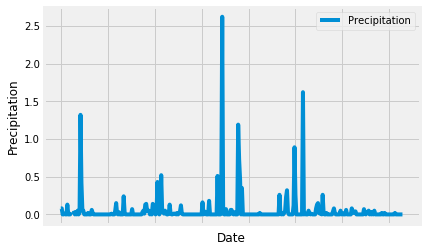

In [15]:
#Plot the results using the DataFrame plot method.

rain_df.plot(x_compat = True)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()

In [16]:
#Use Pandas to print the summary statistics for the precipitation data.

rain_df.describe()

,Precipitation
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [17]:
#Design a query to calculate the total number of stations.

stations = session.query(Station.id).count()
stations

9

In [18]:
#Design a query to find the most active stations.

#List the stations and observation counts in descending order.

s_activity = session.query(Measurement.station, func.count(Measurement\
        .station)).group_by(Measurement.station).order_by(func.count\
        (Measurement.station).desc()).all()
s_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
#Which station has the highest number of observations?

highest_s = s_activity[0][0]
highest_s

'USC00519281'

In [20]:
#Design a query to retrieve the last 12 months of 
#temperature observation data (tobs).

best_s = session.query(Measurement.station, Measurement.tobs).filter\
    (Measurement.station == highest_s).filter(Measurement.date >=\
    '2016-08-24').all()
best_s_df = pd.DataFrame(best_s)
best_s_df.set_index('station', inplace = True)
best_s_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


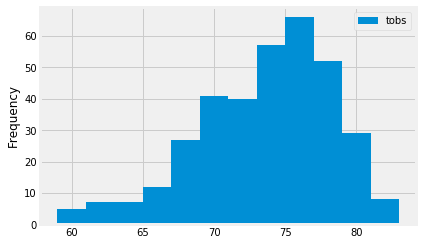

In [21]:
tobs = pd.DataFrame(best_s_df, columns=['tobs'])
tobs.plot.hist(bins=12)
plt.show()

In [22]:
app = Flask(__name__)